In [1]:
!pip install ffmpeg-python
!pip install sounddevice

import matplotlib.pyplot as plt
from IPython.display import HTML, Audio
from base64 import b64decode
import numpy as np
import json


import struct

from scipy.io.wavfile import read as wav_read
from scipy import signal, stats
from scipy.signal import chirp, detrend

import io
import ffmpeg

import sounddevice as sd
import statistics
import matplotlib.pyplot as plt

import time
import numpy as np
from scipy.io import wavfile

In [3]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normalCutoff = cutoff / nyq
    b, a = signal.butter(order, normalCutoff, btype='low')
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

def highpass(data, cutoff, fs, order=4):
    nyq = 0.5 * fs
    norm_cutoff = cutoff / nyq
    b, a = butter(order, norm_cutoff, btype='high')
    return filtfilt(b, a, data)

In [47]:
def play_and_record_chirp(freq_low,freq_high,sample_rate,chirp_duration,total_duration,sd):

    sd.default.channels   = 1
    sd.default.samplerate = sample_rate

    chirp_t               = np.linspace(0, chirp_duration, int(sample_rate*chirp_duration))
    chirp_x               = chirp(chirp_t,f0=freq_low,f1=freq_high,t1=chirp_duration,method='linear').astype(np.float32)
    chirps_needed         = int(total_duration / chirp_duration)
    tx                    = np.tile(chirp_x, chirps_needed)
    rx                    = sd.playrec(tx)

    return tx,rx

In [79]:
# sample_rate = 48000
# freq_low    = 17000
# freq_high   = 23000

# chirp_length   = .1
# total_duration = 30   # extend final sound file to "total_duration" seconds

sample_rate = 48000
freq_low = 18000        # start of chirp (Hz)
freq_high = 20000       # end of chirp (Hz)
chirp_length = 0.1      # duration of each chirp in seconds
total_duration = 15     # total recording time in seconds

tx,rx = play_and_record_chirp(freq_low,freq_high,sample_rate,chirp_length,total_duration,sd)

In [87]:
def preprocess(tx, rx, append=False):
    tx_sig = tx;
    rx_sig = rx[:,0]
    
    num_chirps_recorded = int(rx_sig.shape[0] // (chirp_length * sample_rate))
    
    # trim audio to a whole number of chirps recorded
    rx_sig = rx_sig[:int(num_chirps_recorded * chirp_length * sample_rate)]
    
    rx_data = np.array(np.split(rx_sig, num_chirps_recorded))
    tx_data = np.tile(tx_sig[0:int(chirp_length*sample_rate)], (num_chirps_recorded, 1))
    
    time_to_drop = 1
    segments_to_drop = int(time_to_drop/chirp_length)
    rx_data = rx_data[segments_to_drop:]
    tx_data = tx_data[segments_to_drop:]
    
    window_length = rx_data.shape[1]
    print(window_length)
    
    sample_index = 0
    
    ### save to json for testing ###
    rx_list = rx_data.tolist()
    tx_list = tx_data.tolist()
    if append:
        with open("tx_hrbr.json", "r") as f_tx, open("rx_hrbr.json", "r") as f_rx:
            tx_data = json.load(f_tx)
            rx_data = json.load(f_rx)

        #slide window
        tx_list = tx_data[len(tx_list):] + tx_list
        rx_list = rx_data[len(rx_list):] + rx_list
    print(len(tx_list))
    with open("rx_hrbr.json", "w") as f:
        json.dump(rx_list, f)
    
    with open("tx_hrbr.json", "w") as f:
        json.dump(tx_list, f)
    ### save to json for testing ###

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import detrend, butter, filtfilt, find_peaks, savgol_filter
import json

# --- Load Data ---
def process(plot=False):
    with open("tx_hrbr.json", "r") as f_tx, open("rx_hrbr.json", "r") as f_rx:
        tx_data = json.load(f_tx)
        rx_data = json.load(f_rx)
    
    tx_data = np.array(tx_data)
    rx_data = np.array(rx_data)
    
    window_length = rx_data.shape[1]
    chirp_length = 0.1 
    
    # --- Dechirp ---
    dechirped = rx_data * np.conj(tx_data)
    
    # --- FFT ---
    fft_size = window_length
    fft_data = np.fft.fft(dechirped, n=fft_size, axis=1)
    
    bin_to_track = np.argmax(np.mean(np.abs(fft_data), axis=0))
    phases = np.angle(fft_data[:, bin_to_track])
    unwrapped_phases = np.unwrap(phases)
    detrended_phase = detrend(unwrapped_phases)
    
    # --- Time axis ---
    times = np.arange(unwrapped_phases.shape[0]) * chirp_length
    
    # --- Bandpass filter for HR range (0.67–3.33 Hz = 40–200 BPM) ---
    def bandpass(data, lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return filtfilt(b, a, data)
    
    fs = 1 / chirp_length
    hr_filtered = bandpass(detrended_phase, 45 / 60, 200 / 60, fs)
    
    # --- Smoothed for peak detection ---
    # smoothed = savgol_filter(hr_filtered, window_length=11, polyorder=2)
    def moving_average(x, w):
        return np.convolve(x, np.ones(w)/w, mode='same')
    
    smoothed = moving_average(hr_filtered, w=5)
    
    # --- Peak Detection ---
    peaks, _ = find_peaks(smoothed, height=0.0001, distance=fs/8)
    
    # --- First FFT Estimate ---
    hr_fft = np.fft.rfft(hr_filtered)
    hr_freqs = np.fft.rfftfreq(len(hr_filtered), d=chirp_length)
    hr_bpm_freqs = hr_freqs * 60
    mask1 = (hr_bpm_freqs >= 45) & (hr_bpm_freqs <= 200)
    bpm_freqs_1 = hr_bpm_freqs[mask1]
    fft_mag_1 = np.abs(hr_fft)[mask1]
    
    if len(fft_mag_1) > 5:
        peak_idx_1 = np.argmax(fft_mag_1)
        bpm_fft_1 = bpm_freqs_1[peak_idx_1]
    else:
        bpm_fft_1 = bpm_freqs_1[0]
    
    # --- Estimate BPM from peak intervals ---
    if len(peaks) > 1:
        intervals = np.diff(times[peaks])  # time differences between peaks
        bpms_from_intervals = 60 / intervals  # convert each interval to BPM
    
        # Filter intervals where BPM > initial FFT estimate
        high_bpm_intervals = intervals[bpms_from_intervals > bpm_fft_1]
    
        if len(high_bpm_intervals) > 0:
            high = statistics.mean(high_bpm_intervals)
        else:
            print(f"No intervals correspond to BPM > {bpm_fft_1:.2f}")
    else:
        print("Not enough peaks to compute intervals.")
    
    # if len(peaks) > 1:
    #     intervals = np.diff(times[peaks])
    #     avg_interval = np.mean(intervals)
    #     med = statistics.median(intervals)
    #     bpm_from_peaks = 60 / med
    #     # bpm_from_peaks = (60/14) * len(peaks)
    # else:
    #     bpm_from_peaks = None
    
    # --- Refined FFT Estimate ---
    mask2 = (hr_bpm_freqs > bpm_fft_1) & (hr_bpm_freqs <= 200)
    bpm_freqs_2 = hr_bpm_freqs[mask2]
    fft_mag_2 = np.abs(hr_fft)[mask2]
    
    if len(fft_mag_2) > 5:
        peak_idx_2 = np.argmax(fft_mag_2)
        bpm_fft_2 = bpm_freqs_2[peak_idx_2]
    else:
        bpm_fft_2 = bpm_freqs_2[0]
    
    bpm_from_fft = bpm_fft_1 # change 1 or 2

    if plot:
        # --- Plot Phase vs Time and Peaks ---
        plt.figure(figsize=(10, 4))
        plt.plot(times, smoothed, label='Smoothed Phase')
        plt.plot(times[peaks], smoothed[peaks], 'ro', label='Detected Peaks')
        plt.xlabel("Time (s)")
        plt.ylabel("Phase (radians)")
        plt.title("Phase vs Time with Peak Detection")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
        # --- Plot FFT ---
        plt.figure(figsize=(10, 4))
        plt.plot(bpm_freqs_1, fft_mag_1, label="Initial FFT", linewidth=2)
        plt.axvline(x=bpm_from_fft, color='r', linestyle='--', label=f'FFT HR: {bpm_from_fft:.1f} BPM')
        plt.xlabel("Heart Rate (BPM)")
        plt.ylabel("FFT Magnitude")
        plt.title("FFT-Based Heart Rate Detection")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    # --- Print results ---
    if bpm_from_peaks:
        print(f"Heart Rate (from peak intervals): {bpm_from_peaks:.2f} BPM")
        print(f"Heart Rate (from peak intervals with threshold): {60/high:.2f} BPM")
    else:
        print("Not enough peaks for interval-based heart rate.")
    
    print("Heart Rate (from FFT)", bpm_fft_1, "BPM")
    print(f"Heart Rate (from FFT with threshold): {bpm_from_fft:.2f} BPM")

4800
140


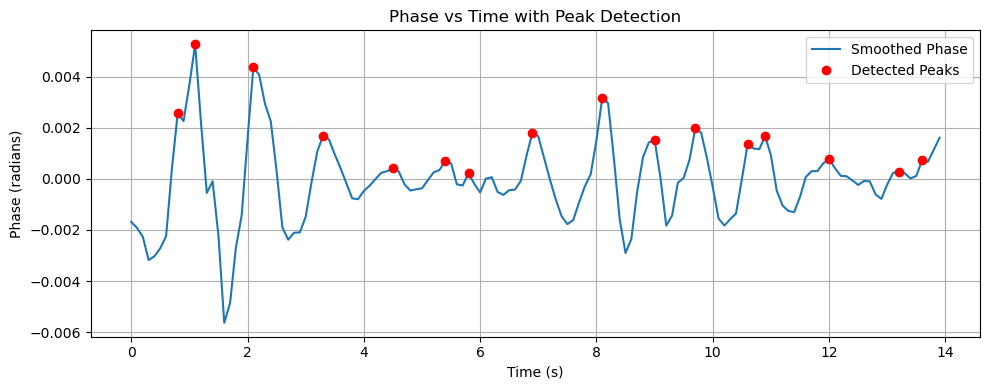

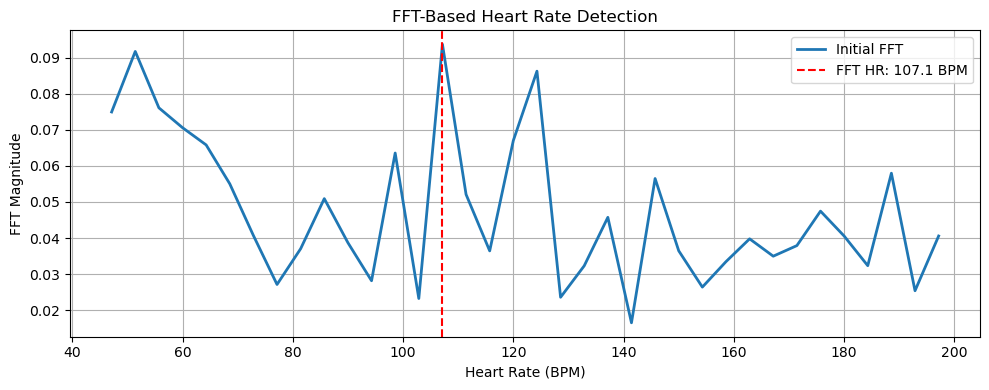

Heart Rate (from peak intervals): 54.55 BPM
Heart Rate (from peak intervals with threshold): 171.43 BPM
Heart Rate (from FFT) 107.14285714285714 BPM
Heart Rate (from FFT with threshold): 107.14 BPM


In [89]:
preprocess(tx,rx)
process(plot=True)

In [103]:
time_left = 30
while time_left > 0:
    ntx, nrx = play_and_record_chirp(freq_low,freq_high,sample_rate,chirp_length, 1,sd)
    tx = np.concatenate([tx, ntx])
    temp = temp[len(ntx):]
    temp2 = np.concatenate([rx, nrx])
    temp2 = temp2[len(nrx):]
    preprocess(temp, temp2)
    process()


(720000, 1)
(48000, 1)
(768000, 1)
(720000, 1)
4800
140
Heart Rate (from peak intervals): 54.55 BPM
Heart Rate (from peak intervals with threshold): 257.14 BPM
Heart Rate (from FFT) 162.85714285714283 BPM
Heart Rate (from FFT with threshold): 162.86 BPM
(720000, 1)
(48000, 1)
(768000, 1)
(720000, 1)
4800
140
Heart Rate (from peak intervals): 54.55 BPM
Heart Rate (from peak intervals with threshold): 187.50 BPM
Heart Rate (from FFT) 81.42857142857142 BPM
Heart Rate (from FFT with threshold): 81.43 BPM
(720000, 1)
(48000, 1)
(768000, 1)
(720000, 1)
4800
140
Heart Rate (from peak intervals): 54.55 BPM
Heart Rate (from peak intervals with threshold): 142.11 BPM
Heart Rate (from FFT) 81.42857142857142 BPM
Heart Rate (from FFT with threshold): 81.43 BPM
(720000, 1)
(48000, 1)
(768000, 1)
(720000, 1)
4800
140
Heart Rate (from peak intervals): 54.55 BPM
Heart Rate (from peak intervals with threshold): 187.50 BPM
Heart Rate (from FFT) 81.42857142857142 BPM
Heart Rate (from FFT with threshold): 

ValueError: array must not contain infs or NaNs